In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import re
import numpy as np
import urllib.request
import json, datetime, math
import time
from datetime import datetime 

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhajj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhajj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def remove_double_space(text):
    return " ".join(text.split())

def remove_punctuation(text):
    if type(text)==float:
        return text
    ans = ""
    for i in text:
        if i not in string.punctuation:
            ans += i
    return ans

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, int(float(value)), ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, int(float(value)), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [35]:
def find_trends(df,ngram):
    control_col = "total_interactions"
    
    df  = df[['posted_at',"name", control_col]]

    df["name"] = df["name"].apply(lambda x: remove_punctuation(x)).str.lower()
    
    df["name"] = df["name"].apply(lambda x: remove_emoji(x))
    
    df["name"] = df["name"].apply(lambda x: remove_double_space(x))

    ## filtering for now

    df = df.sort_values(by="total_interactions", ascending= False)

    df = df.dropna(subset=[control_col])
    
    df["rate"] = pd.qcut(df[control_col],3,labels=["worst", "mid", "best"])

    df[str(ngram)+"_gramed"] = df["name"].apply(lambda x: generate_N_grams(x,ngram=ngram,stopwords = all_stopwords))

    list_best = []
    for row in range(len(df.loc[df["rate"] == "best"][str(ngram)+"_gramed"].reset_index(drop=True))):
        for gram in df.loc[df["rate"] == "best"][str(ngram)+"_gramed"].reset_index(drop=True)[row]:
            list_best.append(gram.strip())

    list_worst = []
    for row in range(len(df.loc[df["rate"] == "worst"][str(ngram)+"_gramed"].reset_index(drop=True))):
        for gram in df.loc[df["rate"] == "worst"][str(ngram)+"_gramed"].reset_index(drop=True)[row]:
            list_worst.append(gram.strip())

    best50 = pd.Series(list_best).value_counts()[:100]

    worst50 = pd.Series(list_worst).value_counts()[:100]

    cond = best50.reset_index()["index"].isin(worst50.reset_index()["index"]) == False

    df_final_best = best50.reset_index().loc[cond,:]

    # dropping channelname-inclded results
    drop_cond = ["avocado couple", "la la", "go like", "la life", "go food", "", "baby zoo"]
    return df_final_best[df_final_best["index"].isin(drop_cond) == False]


In [36]:
def generate_N_grams(text,ngram=1,stopwords=set(stopwords.words('english'))):
    words=[word for word in text.split(" ") if (word not in stopwords) & (word != "")]  
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) if (ngram not in stopwords) else "" for ngram in temp]
    intersect_list = [value for value in ans if value in stopwords]
    
    return list(set(ans) - set(intersect_list))

def sentence_similarity(X,Y):

    # tokenization
    X_list = word_tokenize(X)
    Y_list = word_tokenize(Y)

    # sw contains the list of stopwords
    sw = stopwords.words('english')
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw}
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings
    rvector = X_set.union(Y_set)
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula
    for i in range(len(rvector)):
            c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine


In [37]:
def get_cum_views(df,df_2gram):
    
    control_col = "total_interactions"

    df_interactions = df[["name", "total_interactions"]]

    df_interactions["name"] = df_interactions["name"].str.lower().apply(lambda x : remove_punctuation(x))
    df_interactions["name"] = df_interactions["name"].apply(lambda x: remove_emoji(x))
    
    df_interactions["name"] = df_interactions["name"].apply(lambda x: remove_double_space(x))
    
    #tempo
    df_interactions = df_interactions.sort_values(by="total_interactions", ascending= False)

    df_interactions = df_interactions.dropna(subset=[control_col])

    df_interactions["rate"] = pd.qcut(df_interactions[control_col],3,labels=["worst", "mid", "best"])
    #tempo

    df_interactions = df_interactions.dropna(subset=[control_col])

    df_interactions["name"] = df_interactions["name"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

    df_2gram['total_interactions_cum'] = np.nan

    df_2gram = df_2gram.dropna(subset=["kw"]).reset_index(drop=True)

    for i in range(len(df_2gram["kw"])):
        df_2gram.loc[i,"total_interactions_cum"] = df_interactions[df_interactions["name"].str.contains(df_2gram["kw"].reset_index(drop=True)[i])]["total_interactions"].sum()
    #     print(i,"done")

    return df_2gram

In [38]:
def main(df_videos,ngram):
    df_2gram = find_trends(df_videos,ngram)

    df_2gram = df_2gram.rename(columns = {"index" : "kw", 0 : "used"})

    df_2gram = df_2gram.reset_index(drop=True)

    df_2gram = get_cum_views(df_videos,df_2gram)

    for kw_i in range(len(df_2gram['kw'])):
        for kw2_i in range(kw_i,len(df_2gram["kw"])):
            if (sentence_similarity(df_2gram["kw"][kw_i],df_2gram["kw"][kw2_i]) >= 0.4) & (kw_i != kw2_i):

                df_2gram.loc[kw2_i,"kw"] = df_2gram["kw"][kw_i]

    df_2gram_grouped = df_2gram.groupby("kw").sum().reset_index().sort_values(by="used", ascending = False).reset_index(drop=True)

    df_2gram_grouped["avg_total_interactions"] = df_2gram_grouped["total_interactions_cum"] / df_2gram_grouped["used"]

    df_2gram_grouped = df_2gram_grouped.sort_values(by="used",ascending=False)
    
    return df_2gram_grouped

In [39]:
def main_worst(df_videos):
    df_2gram = find_trends_worst(df_videos,5)

    df_2gram = df_2gram.rename(columns = {"index" : "kw", 0 : "used"})

    df_2gram = df_2gram.reset_index(drop=True)

    df_2gram = get_cum_views(df_videos,df_2gram)

    for kw_i in range(len(df_2gram['kw'])):
        for kw2_i in range(kw_i,len(df_2gram["kw"])):
            if (sentence_similarity(df_2gram["kw"][kw_i],df_2gram["kw"][kw2_i]) >= 0.4) & (kw_i != kw2_i):

                df_2gram.loc[kw2_i,"kw"] = df_2gram["kw"][kw_i]

    df_2gram_grouped = df_2gram.groupby("kw").sum().reset_index().sort_values(by="used", ascending = False).reset_index(drop=True)

    df_2gram_grouped["avg_total_interactions"] = df_2gram_grouped["total_interactions_cum"] / df_2gram_grouped["used"]

    df_2gram_grouped = df_2gram_grouped.sort_values(by="used",ascending=False)
    
    return df_2gram_grouped

In [40]:
# Read data of facebook post of ABC news and CBS news
data_abc = pd.read_csv(r"C:\Users\hhajj\Python codes\Keyword_Analysis\abc_news.csv")
data_cbs = pd.read_csv(r"C:\Users\hhajj\Python codes\Keyword_Analysis\cbs_news.csv")

In [41]:
# Create a column named 'total_interactions' as the sum of interactions
col_list = ['likes_count','comments_count','shares_count','love_count','wow_count','haha_count','sad_count','thankful_count','angry_count']
data_abc["total_interactions"] = data_abc[col_list].sum(axis=1)
data_cbs["total_interactions"] = data_cbs[col_list].sum(axis=1)

# Remove rows with NAs for 'name' and 'total_interactions' columns
data_abc = data_abc[data_abc['name'].notna()]
data_abc = data_abc[data_abc['total_interactions'].notna()]

data_cbs = data_cbs[data_cbs['name'].notna()]
data_cbs = data_cbs[data_cbs['total_interactions'].notna()]

# Define Stopwords
all_stopwords= nltk.corpus.stopwords.words('english')
all_stopwords.extend(["123","shorts", "smol", "avacado", "la", "go like","5minute","go", "gold","baby zoo"])


In [42]:
def plot_keywords(data):
    ### data pre-processing

    # transform the date-time column
    data["posted_at"] = pd.to_datetime(data["posted_at"])
    # Create a sub data
    data_temp = data[["posted_at","name","total_interactions"]]
    # Create a new column with corresponding month
    data_temp["date_month"] = pd.to_datetime(data_temp['posted_at']).dt.to_period('M')
    # Sort data by months
    data_temp = data_temp.sort_values(by="date_month")
    # Create an empty data
    data_monthly = pd.DataFrame()
    # Fill the data with corresponidng keywords
    for month in data_temp["date_month"].unique():
        data_temp2 = main(data_temp.loc[data_temp["date_month"] == month],3)
        data_temp2["date_month"] = month
        data_monthly = pd.concat([data_monthly,data_temp2[:10]])
    # Get keywords used more than 1
    data_monthly = data_monthly.loc[data_monthly["used"] != 1].reset_index(drop=True)
    # transform the 'date_month' column to str
    data_monthly["date_month"] = data_monthly["date_month"].astype("str")

    ### Plotting for the last 3 months

    for i in data_monthly['date_month'].unique()[-3:,]:
        # Define the plot size, axes, title
        plt.figure(figsize=[8,6])
        fig, axes = plt.subplots(1, 2,sharey=True,figsize=(20,10))
        fig.suptitle('{} : Times used vs Average Interactions'.format(i), fontsize=24)
        # First plot is how many times keywords were used
        p = sns.barplot(data=data_monthly.loc[data_monthly["date_month"] == i],y="kw", x="used" , ax=axes[0])
        show_values(p, "h", space=0)
        axes[0].set_title('Times Used of Keyword Series')
        # Second plot is the corresponding average number of interactions
        q = sns.barplot(data=data_monthly.loc[data_monthly["date_month"] ==  i],y="kw", x="avg_total_interactions" , ax=axes[1])
        show_values(q, "h", space=0)
        axes[1].set_title('Average number of interactions')


## ABC news :

<Figure size 576x432 with 0 Axes>

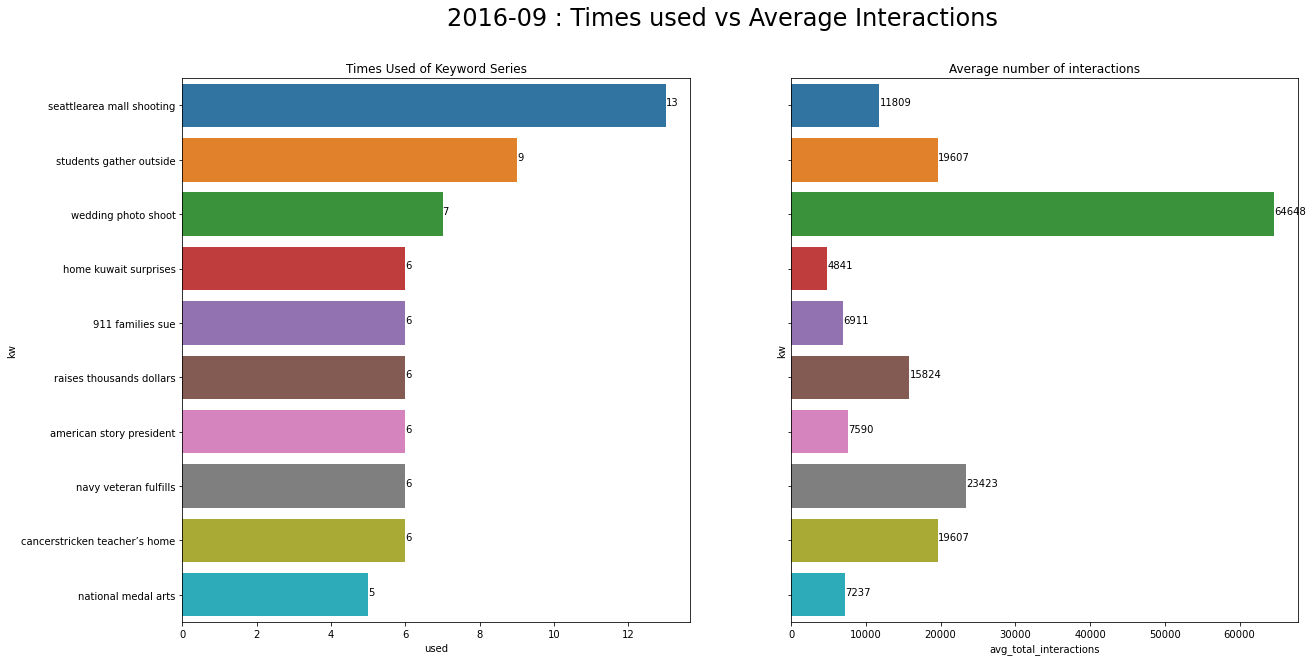

<Figure size 576x432 with 0 Axes>

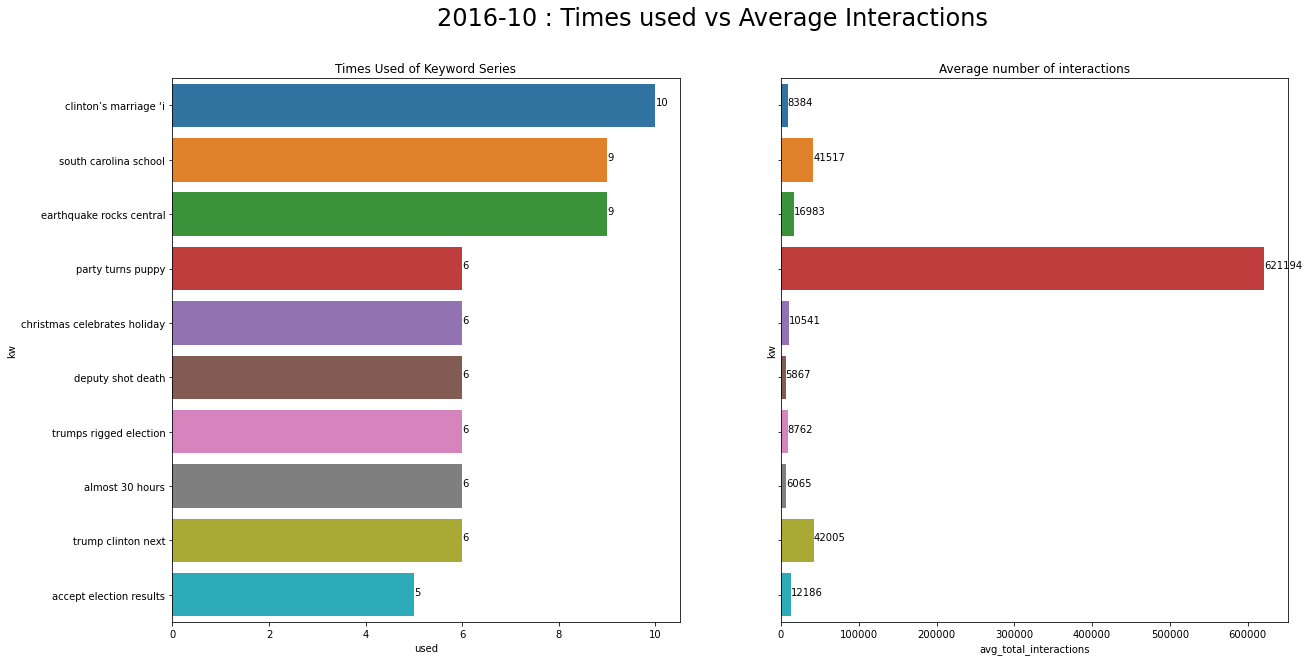

<Figure size 576x432 with 0 Axes>

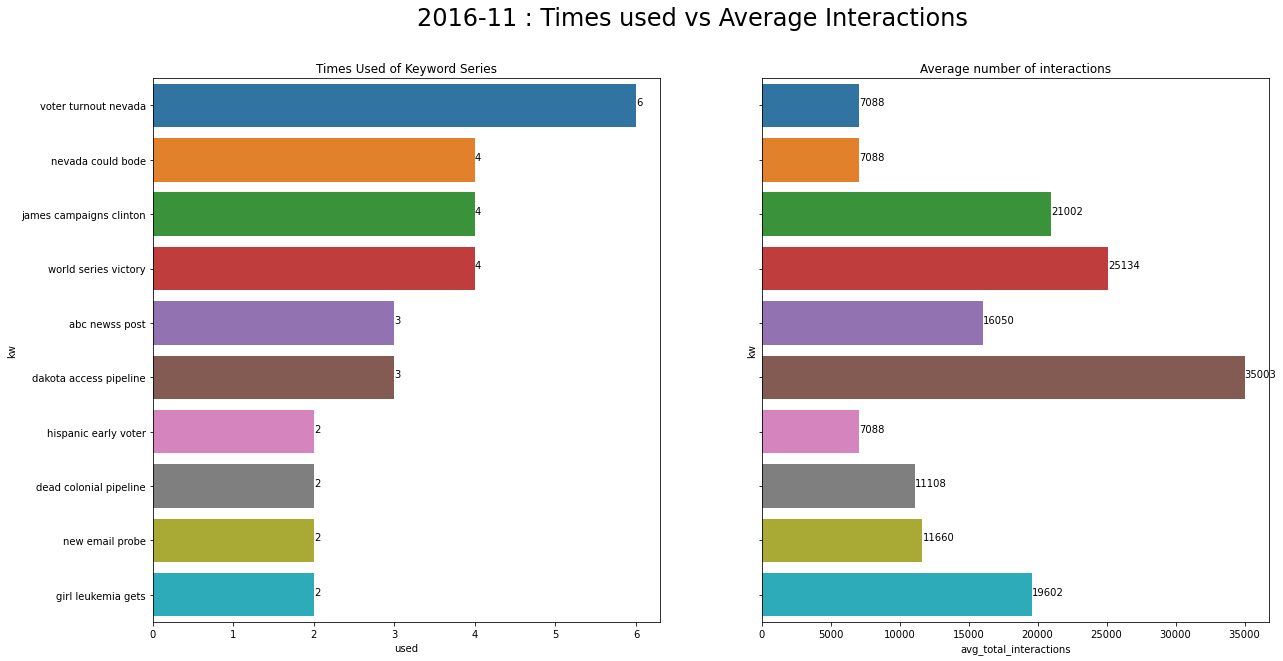

In [43]:
plot_keywords(data_abc)

## CBS news

<Figure size 576x432 with 0 Axes>

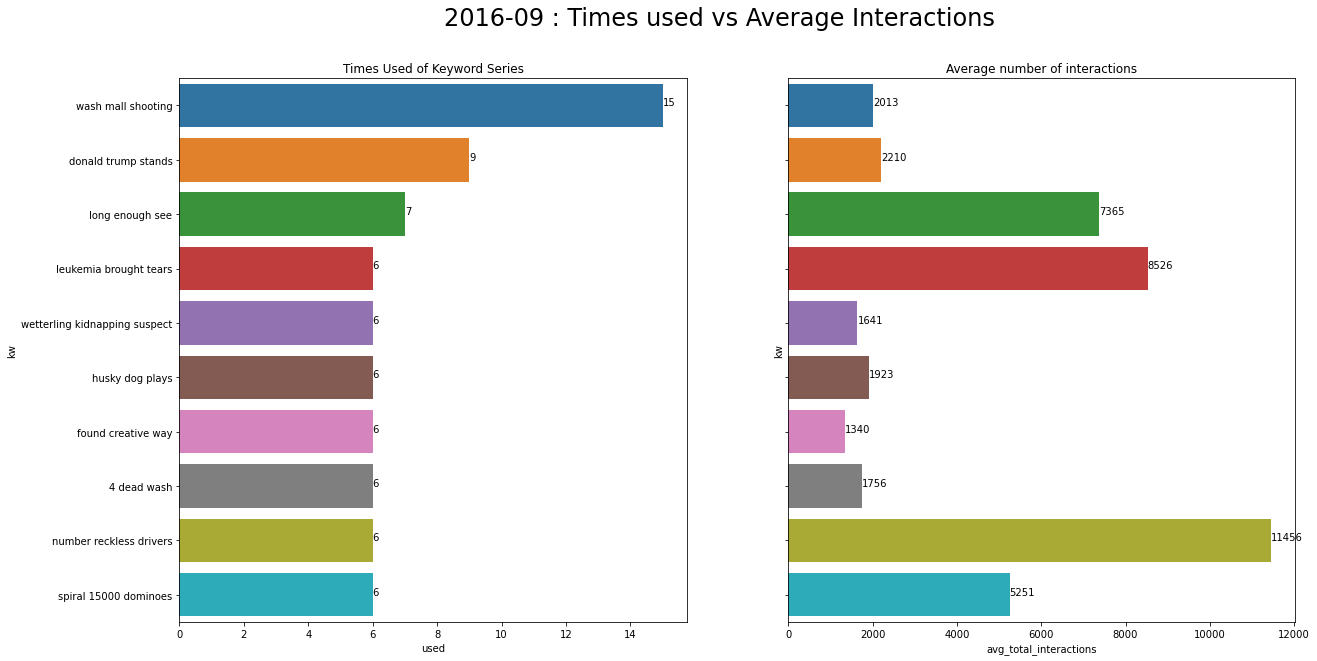

<Figure size 576x432 with 0 Axes>

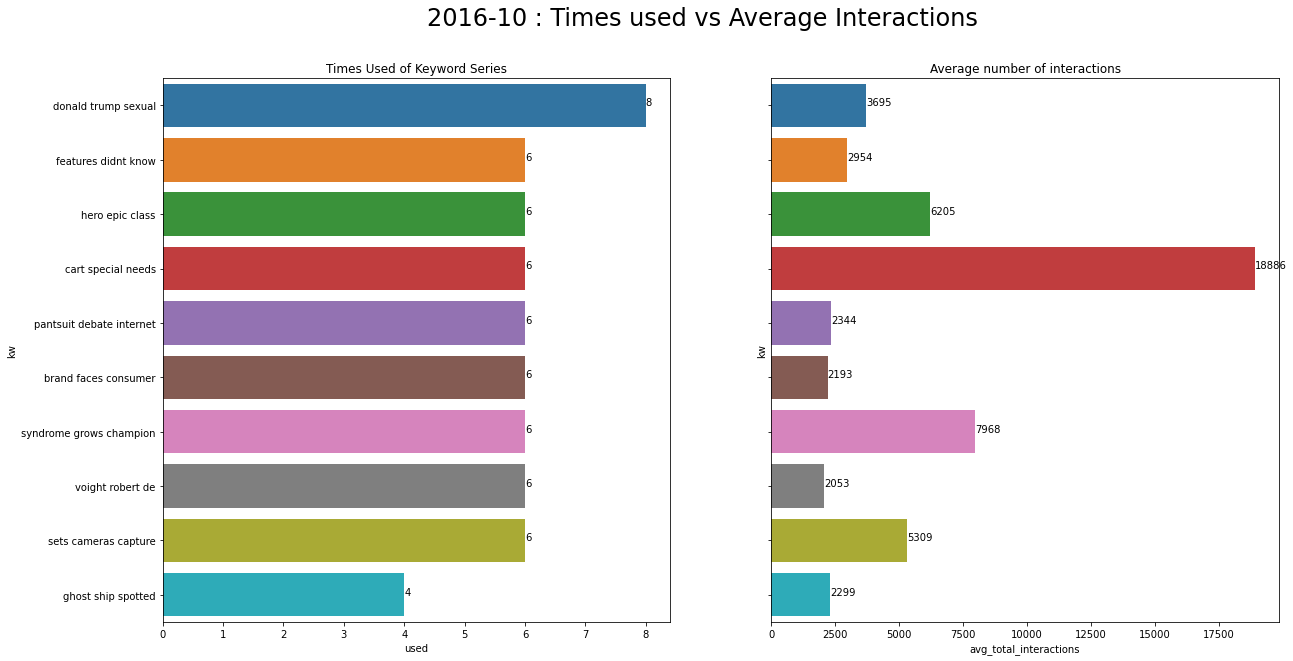

<Figure size 576x432 with 0 Axes>

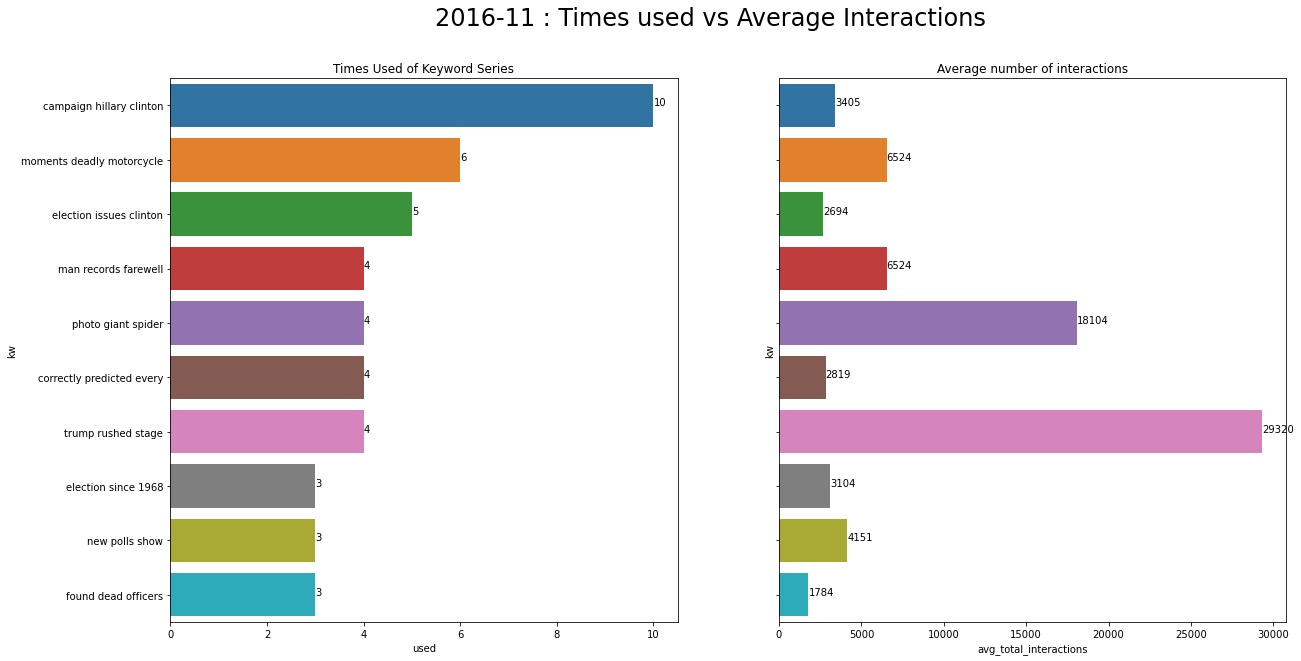

In [44]:
plot_keywords(data_cbs)